In [1]:
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
import mteb
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer, models, InputExample, losses
from sentence_transformers.datasets import DenoisingAutoEncoderDataset
from torch.utils.data import DataLoader
import torch
import nltk

nltk.download('punkt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

[nltk_data] Downloading package punkt to
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load the sentence-transformer model, using gte-large as base model
def get_gte_model():
    name = 'thenlper/gte-large'
    transformer = models.Transformer(name)
    pooling = models.Pooling(transformer.get_word_embedding_dimension(), 'mean')
    model = SentenceTransformer(modules = [transformer, pooling])
    tokenizer = AutoTokenizer.from_pretrained('thenlper/gte-large')
    return model, tokenizer

model, tokenizer = get_gte_model()

# Load the scifact dataset consits of expert written claims with a title and a generated query
# Each text appears 3 times with different queries
corpus = load_dataset('BeIR/scifact-generated-queries')['train']

print(len(corpus))
print(corpus[0])  # has 'title', 'text' and an according 'query'

15422
{'_id': '4983', 'title': 'Microstructural development of human newborn cerebral white matter assessed in vivo by diffusion tensor magnetic resonance imaging.', 'text': 'Alterations of the architecture of cerebral white matter in the developing human brain can affect cortical development and result in functional disabilities. A line scan diffusion-weighted magnetic resonance imaging (MRI) sequence with diffusion tensor analysis was applied to measure the apparent diffusion coefficient, to calculate relative anisotropy, and to delineate three-dimensional fiber architecture in cerebral white matter in preterm (n = 17) and full-term infants (n = 7). To assess effects of prematurity on cerebral white matter development, early gestation preterm infants (n = 10) were studied a second time at term. In the central white matter the mean apparent diffusion coefficient at 28 wk was high, 1.8 microm2/ms, and decreased toward term to 1.2 microm2/ms. In the posterior limb of the internal capsul

## Unsupervised Finetuning
Below cells train different models using `MultipleNegativesRankingLoss`, `GISTEmbedLoss` and `DenoisingAutoEncoderLoss` 

In [4]:
# Create sentences for the finetuning
# It can be useful to introduce more variety in them or focus on specific types of sentences depending on the desired outcome
num_sentences = 10_000
sentences = []

for i in range(0, min(num_sentences*6, len(corpus)), 3):
    text = corpus[i]['title'] + '\n' + corpus[i]['text']
    query = corpus[i]['query']

    tok_sentences = nltk.sent_tokenize(text)
    tok_sentences = [s for s in tok_sentences if 5 <= len(s.split()) < 300 ] 
    sentences.extend(tok_sentences)
    
sentences = sentences[:num_sentences]
print(f"created {len(sentences)} sentences")

created 10000 sentences
Microstructural development of human newborn cerebral white matter assessed in vivo by diffusion tensor magnetic resonance imaging.
Alterations of the architecture of cerebral white matter in the developing human brain can affect cortical development and result in functional disabilities.
A line scan diffusion-weighted magnetic resonance imaging (MRI) sequence with diffusion tensor analysis was applied to measure the apparent diffusion coefficient, to calculate relative anisotropy, and to delineate three-dimensional fiber architecture in cerebral white matter in preterm (n = 17) and full-term infants (n = 7).


In [15]:
# TSDAE training 
# uses (sentence, noisy sentence) as positive pair
# standard noise fn of DenoisingAutoEncoderDataset deletes 60% of tokens
tsdae_data = DenoisingAutoEncoderDataset(sentences)
model = get_gte_model()[0]
dataloader = DataLoader(tsdae_data, batch_size=32, shuffle=True)
train_loss = losses.DenoisingAutoEncoderLoss(model, decoder_name_or_path='thenlper/gte-large', tie_encoder_decoder=True)

model.fit(
    train_objectives=[(dataloader, train_loss)],
    epochs=1,
    scheduler='constantlr',
    weight_decay=0,
    optimizer_params={'lr': 3e-5},
    show_progress_bar=True,
    )
model.save('tsdae_model')

Step,Training Loss


In [13]:
# SimCSE training using MNRL
# train the model on those sentences using different losses with simcse method
# uses embedding of same sentence as positive pair because embeddings differ due to dropout noise
simcse_data = [InputExample(texts=[s, s]) for s in sentences]
model = get_gte_model()[0]
dataloader = DataLoader(simcse_data, batch_size=32, shuffle=True)
train_loss = losses.MultipleNegativesRankingLoss(model)

model.fit(
    train_objectives=[(dataloader, train_loss)],
    epochs=1,
    show_progress_bar=True,
    optimizer_params={'lr': 3e-6},
    )
model.save('mnrl_model')

Step,Training Loss


In [11]:
# SimCSE with GISTEmbed
# gistembed loss uses a guide model providing similarity scores which the trained model tries to mimic
simcse_data = [InputExample(texts=[s, s]) for s in sentences]
model = get_gte_model()[0]
dataloader = DataLoader(simcse_data, batch_size=32, shuffle=True)
train_loss = losses.GISTEmbedLoss(model, guide=SentenceTransformer('thenlper/gte-large'))

model.fit(
    train_objectives=[(dataloader, train_loss)],
    epochs=1,
    show_progress_bar=True,
    optimizer_params={'lr': 3e-6},
    )
model.save('gistembed_model')

Step,Training Loss
500,2.410500


## Supervised finetuning
Simply construct positive pairs as query + text, one could also incorporate the title here

In [44]:
# MultipleNegativeRankingsLoss using positive pairs (query, text)
data = [InputExample(texts=[corpus[i]['query'], corpus[i]['text']]) for i in range(10_000)]
model = get_gte_model()[0]
dataloader = DataLoader(data, batch_size=32, shuffle=True)
train_loss = losses.MultipleNegativesRankingLoss(model)

model.fit(
    train_objectives=[(dataloader, train_loss)],
    epochs=1,
    optimizer_params={'lr': 3e-6},
    show_progress_bar=True,
    )
model.save('sup_mnrl_model')

Step,Training Loss
500,0.939200


## Retrieval evaluation using the mteb lib

In [45]:
model_names = ['gte', 'mnrl_model', 'gistembed_model', 'tsdae_model', 'sup_mnrl_model']
model_names = ['mnrl_model', 'gistembed_model', 'tsdae_model']
model_names = ['sup_mnrl_model']
result_dict = {}

for name in model_names:
    if name == 'gte':
        model = get_gte_model()[0]
    else:
        model = SentenceTransformer(name)
    
    model.eval()
    tasks = mteb.get_tasks(languages=['eng'], tasks=["SciFact"])
    evaluation = mteb.MTEB(tasks=tasks)

    # Model needs a revision not None else mteb lib throws an error
    if not hasattr(model, 'revision') or model.revision is None:
        model.revision = "default_revision"

    results = evaluation.run(model, output_folder="./results", overwrite_results=True)

    for result in results:
        ndcg1 = dict(result)['scores']['test'][0]['ndcg_at_1']
        ndcg10 = dict(result)['scores']['test'][0]['ndcg_at_10']
        ndcg100 = dict(result)['scores']['test'][0]['ndcg_at_100']
        ndcg1000 = dict(result)['scores']['test'][0]['ndcg_at_1000']

    result_dict[name] = [ndcg1, ndcg10, ndcg100, ndcg1000]
print(result_dict)

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

Batches: 100%|██████████| 41/41 [01:21<00:00,  1.98s/it]


{'sup_mnrl_model': [0.62, 0.73837, 0.75901, 0.76373]}


In [40]:
# best results from evaluation for NDCG@1,10,100,1000
result_dict = {}
result_dict['gte'] = [0.62333, 0.74169, 0.76358, 0.76826]
result_dict['tsdae_model'] = [0.62333, 0.74303, 0.76448, 0.76916]
result_dict['mnrl_model'] = [0.63, 0.74829, 0.76733, 0.77107]
result_dict['gistembed_model'] = [0.63333, 0.74455, 0.76671, 0.77137]
result_dict['sup_mnrl_model'] = [0.62667, 0.74723, 0.76631, 0.77005]

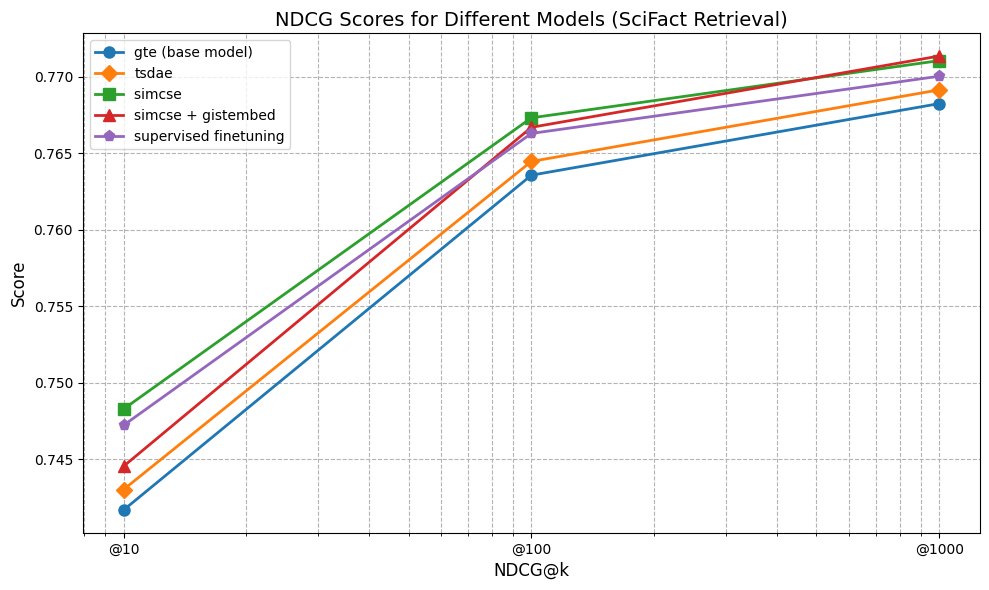

In [41]:
# Visualize results for NDCG@10,100,1000
import matplotlib.pyplot as plt

x_values = [10, 100, 1000]
markers = {'gte': 'o', 'mnrl_model': 's', 'gistembed_model': '^', 'tsdae_model': 'D', 'sup_mnrl_model':'p'}
labels = {'gte': 'gte (base model)', 'mnrl_model': 'simcse ', 'gistembed_model': 'simcse + gistembed', 'tsdae_model': 'tsdae', 'sup_mnrl_model': 'supervised finetuning'}
plt.figure(figsize=(10, 6))

for model, values in result_dict.items():
    label = labels[model]
    plt.plot(x_values, values[1:], marker=markers[model], label=label, linewidth=2, markersize=8)

plt.xscale('log')  # Use log scale for x-axis
plt.xlabel('NDCG@k', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('NDCG Scores for Different Models (SciFact Retrieval)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which="both", ls="--", c='0.7')

plt.xticks(x_values, [f'@{x}' for x in x_values])

plt.tight_layout()
plt.savefig('results.png')
plt.show()